# COMP47590: Advanced Machine Learning
# Assignment 1: Multi-label Classification

Name(s): Xiao Li

Student Number(s): 15206109

## Import Packages Etc

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import hamming_loss, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils.multiclass import unique_labels
from sklearn import metrics
from imblearn.under_sampling import RandomUnderSampler


Using TensorFlow backend.
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py

## Task 0: Load the Yeast Dataset

In [3]:
# Read the csv file
dataSet = pd.read_csv("yeast.csv")
dataSet

,Att1,Att2,Att3,Att4,Att5,Att6,Att7,Att8,Att9,Att10,...,Class5,Class6,Class7,Class8,Class9,Class10,Class11,Class12,Class13,Class14
0,0.004168,-0.170975,-0.156748,-0.142151,0.058781,0.026851,0.197719,0.041850,0.066938,-0.056617,...,0,0,1,1,0,0,0,1,1,0
1,-0.103956,0.011879,-0.098986,-0.054501,-0.007970,0.049113,-0.030580,-0.077933,-0.080529,-0.016267,...,0,0,0,0,0,0,0,0,0,0
2,0.509949,0.401709,0.293799,0.087714,0.011686,-0.006411,-0.006255,0.013646,-0.040666,-0.024447,...,0,0,0,0,0,0,0,1,1,0
3,0.119092,0.004412,-0.002262,0.072254,0.044512,-0.051467,0.074686,-0.007670,0.079438,0.062184,...,0,0,0,0,0,0,0,0,0,0
4,0.042037,0.007054,-0.069483,0.081015,-0.048207,0.089446,-0.004947,0.064456,-0.133387,0.068878,...,1,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2412,-0.119784,0.001259,-0.123645,-0.015513,-0.059683,0.091032,-0.043302,0.229219,-0.071498,0.182709,...,0,0,0,0,0,0,0,0,0,0
2413,0.085327,0.058590,0.085268,-0.020897,0.068972,0.030125,0.078056,0.011346,0.052618,0.066093,...,0,0,0,0,0,0,0,1,1,0
2414,0.082526,-0.095571,-0.022019,-0.046793,-0.038360,0.041084,0.056509,0.011749,-0.029657,-0.012198,...,0,1,1,1,0,0,0,1,1,0
2415,-0.130830,0.008868,-0.009457,-0.058930,-0.041224,0.042269,0.117717,0.037388,-0.085563,0.136649,...,0,0,0,0,0,0,0,1,1,0


In [3]:
# Split the data set into description feature set and functional classses set.
desFeatures = np.array(dataSet.iloc[:,:103])
funcClasses = np.array(dataSet.iloc[:,103:])

# Obtain all the labels from the functional class
func_labels = list(dataSet.columns.values[103:])

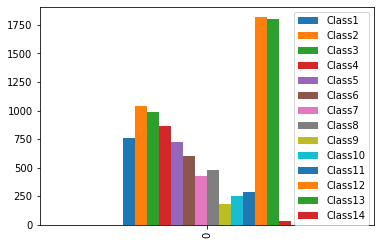

In [4]:
# Show each class count number
classes = dict()
for class_ in range(funcClasses[0].size):
    key = "Class" + str(class_ + 1)
    value = dataSet.iloc[:, 103 + class_].value_counts()[1]
    classes[key] = [value]
graph = pd.DataFrame.from_dict(classes)
graph.plot(kind = "bar")

## Task 1: Implement the Binary Relevance Algorithm

In [5]:
# Binary relevance algorithms
class BinaryRelevance():
    
    # Constructor: input the classifer and the labels of the functional class
    def __init__(self, classifier, labels):
        self.models = dict()
        self.labels = labels
        self.classifier = classifier
    
    # Fit function, train the classifier
    def fit(self, data_train, func_train):
        # the features in all columns, except the class label part
        X = data_train
        
        # Iterate all class labels, create each model
        for i in range(len(self.labels)):
            
            # Obtain the current label
            y = np.transpose(func_train[:, i])
            
            # Use the specific classifier to train the model
            self.models[i] = self.classifier().fit(X, y)
        return self
            
    # The prediction function
    def predict(self, X):
        
        # Initialized an empty list to store all predictions
        pred = list()
        
        # Iterate all class labels to get each prediction
        for i in range(len(self.labels)):
            pred.append(self.models[i].predict(X))
            
        return np.transpose(np.array(pred))
    

## Task 2: Implement the Binary Relevance Algorithm with Under-Sampling

In [6]:
# Binary relevance algorithms with under-sampling
class BinaryRelevance_UnderS():
    
    # Constructor: input classifier, class labels and the boolean value of whether under-sampling, which true in default 
    def __init__(self, classifier, labels, underS = True):
        self.models = dict()
        self.labels = labels
        self.classifier = classifier
        self.underS = underS
        
    # Fit function, train the classifier
    def fit(self, data_train, func_train):
        # Generate an under sampler
        underSample = RandomUnderSampler(random_state = 0)
        X = data_train
        
        # Iterate all class labels, create each model
        for i in range(len(self.labels)):
            
            # Obtain the current label
            y = np.transpose(func_train[:, i])
            
            # Whether use the under-sampling
            if self.underS:
                X_bal, y_bal = underSample.fit_sample(X, y)
                
            # Use the specific classifier to train the model
            self.models[i] = self.classifier().fit(X_bal, y_bal)
        
        return self
            
    def predict(self, X):
        
        # Initialized an empty list to store all predictions
        pred = list()
        
        # Iterate all class labels to get each prediction
        for i in range(len(self.labels)):
            pred.append(self.models[i].predict(X))
        
        return np.transpose(np.array(pred))


## Task 3: Compare the Performance of Different Binary Relevance Approaches

In [18]:
# Split the origin dataset in ratio 7:3
data_train, data_test, func_train, func_test = train_test_split(desFeatures, funcClasses, random_state = 0, train_size = 0.7)

In [28]:
# Generate a Binary relevance classifier without sampling
br = BinaryRelevance(GaussianNB, func_labels)
br.fit(data_train, func_train)
func_pred = br.predict(data_test)

# Calculate the hamming loss
br_hamming_loss = hamming_loss(func_test, func_pred)

# Calculate the f1 score
br_f1_score = f1_score(func_test, func_pred, average = "macro")


# Generate a Binary relevance classifier with sampling
br_us = BinaryRelevance_UnderS(GaussianNB, func_labels, True)
br_us.fit(data_train, func_train)
func_us_pred = br_us.predict(data_test)

# Calculate the hamming loss
br_us_hamming_loss = hamming_loss(func_test, func_us_pred)

# Calculate the f1 score
br_us_f1_score = f1_score(func_test, func_us_pred, average = "macro")

print("GaussianNB classifier without sampling:\n")
print("\t- Hamming Loss: ", br_hamming_loss, "\n")
print("\t- F1 Score: ", br_f1_score)

print("\n\nGaussianNB classifier with sampling:\n")
print("\t- Hamming Loss: ", br_us_hamming_loss, "\n")
print("\t- F1 Score: ", br_us_f1_score)

GaussianNB classifier without sampling:

	- Hamming Loss:  0.2973238882329791 

	- F1 Score:  0.4441966958169542


GaussianNB classifier with sampling:

	- Hamming Loss:  0.37298307752853205 

	- F1 Score:  0.4393360855066418


In [26]:
# Generate a Binary relevance classifier without sampling
br = BinaryRelevance(KNeighborsClassifier, func_labels)
br.fit(data_train, func_train)
func_pred = br.predict(data_test)

# Calculate the hamming loss
br_hamming_loss = hamming_loss(func_test, func_pred)

# Calculate the f1 score
br_f1_score = f1_score(func_test, func_pred, average = "macro")


# Generate a Binary relevance classifier with sampling
br_us = BinaryRelevance_UnderS(KNeighborsClassifier, func_labels, True)
br_us.fit(data_train, func_train)
func_us_pred = br_us.predict(data_test)

# Calculate the hamming loss
br_us_hamming_loss = hamming_loss(func_test, func_us_pred)

# Calculate the f1 score
br_us_f1_score = f1_score(func_test, func_us_pred, average = "macro")

print("KNeighbors classifier without sampling:\n")
print("\t- Hamming Loss: ", br_hamming_loss, "\n")
print("\t- F1 Score: ", br_f1_score)

print("\n\nKNeighbors classifier with sampling:\n")
print("\t- Hamming Loss: ", br_us_hamming_loss, "\n")
print("\t- F1 Score: ", br_us_f1_score)

KNeighbors classifier without sampling:

	- Hamming Loss:  0.21054702872884692 

	- F1 Score:  0.4171119638846602


KNeighbors classifier with sampling:

	- Hamming Loss:  0.3724911452184179 

	- F1 Score:  0.4435257841700581


In [30]:
# Generate a Binary relevance classifier without sampling
br = BinaryRelevance(LogisticRegression, func_labels)
br.fit(data_train, func_train)
func_pred = br.predict(data_test)

# Calculate the hamming loss
br_hamming_loss = hamming_loss(func_test, func_pred)

# Calculate the f1 score
br_f1_score = f1_score(func_test, func_pred, average = "macro")


# Generate a Binary relevance classifier with sampling
br_us = BinaryRelevance_UnderS(LogisticRegression, func_labels, True)
br_us.fit(data_train, func_train)
func_us_pred = br_us.predict(data_test)

# Calculate the hamming loss
br_us_hamming_loss = hamming_loss(func_test, func_us_pred)

# Calculate the f1 score
br_us_f1_score = f1_score(func_test, func_us_pred, average = "macro")

print("LogisticRegression classifier without sampling:\n")
print("\t- Hamming Loss: ", br_hamming_loss, "\n")
print("\t- F1 Score: ", br_f1_score)

print("\n\nLogisticRegression classifier with sampling:\n")
print("\t- Hamming Loss: ", br_us_hamming_loss, "\n")
print("\t- F1 Score: ", br_us_f1_score)

LogisticRegression classifier without sampling:

	- Hamming Loss:  0.2085792994883904 

	- F1 Score:  0.3361452699253122


LogisticRegression classifier with sampling:

	- Hamming Loss:  0.3737701692247147 

	- F1 Score:  0.4354239044216425


## Task 4: Implement the Classifier Chains Algorithm

In [31]:
# Classifier Chains algorithms
class ClassifierChains():
    
    # Constructor: input the classifer and the labels of the functional class
    def __init__(self, classifier, labels):
        self.models = dict()
        self.labels = labels
        self.classifier = classifier
        
    # Fit function, train the classifier
    def fit(self, data_train, func_train):
        
        # Select the train set from the feature set
        X = data_train[:, :103]
        
        # Iterate all class labels, create each model
        for i in range(len(self.labels)):
            y = np.transpose(func_train[:, i])
            self.models[i] = self.classifier().fit(X, y)
            
            # Chain here, to connect X and y
            X = np.c_[X, y]
            
        return self
           
    # The prediction function
    def predict(self, X):
        
        # Initialized an empty list to store all predictions
        pred = list()
        
        # Iterate all class labels to get each prediction
        for i in range(len(self.labels)):
            pred.append(self.models[i].predict(X[:, :103+i]))
        
        return np.transpose(np.array(pred))

## Task 5: Evaluate the Performance of the Classifier Chains Algorithm

In [16]:
# Generate a new data set
data_cc = np.array(dataSet)

# Slipt the train set and test set from the feature and class labels
data_train_cc, data_test_cc, func_train_cc, func_test_cc = train_test_split(data_cc, funcClasses, random_state = 0, train_size = 0.7)

In [38]:
# Generate a Classifier Chain classifier
cc = ClassifierChains(GaussianNB, func_labels)
cc.fit(data_train_cc, func_train_cc)
func_pred_cc = cc.predict(data_test_cc)

# Calculate the hamming loss
cc_hamming_loss = hamming_loss(func_test_cc, func_pred_cc)

# Calculate the f1 score
cc_f1_score = f1_score(func_test_cc, func_pred_cc, average = "macro")


# Generate a Binary relevance classifier without sampling
br = BinaryRelevance(GaussianNB, func_labels)
br.fit(data_train, func_train)
func_pred = br.predict(data_test)

# Calculate the hamming loss
br_hamming_loss = hamming_loss(func_test, func_pred)

# Calculate the f1 score
br_f1_score = f1_score(func_test, func_pred, average = "macro")


# Generate a Binary relevance classifier with sampling
br_us = BinaryRelevance_UnderS(GaussianNB, func_labels, True)
br_us.fit(data_train, func_train)
func_us_pred = br_us.predict(data_test)

# Calculate the hamming loss
br_us_hamming_loss = hamming_loss(func_test, func_us_pred)

# Calculate the f1 score
br_us_f1_score = f1_score(func_test, func_us_pred, average = "macro")

print("GaussianNB classifier with Classifier Chain:\n")
print("\t- Hamming Loss: ", cc_hamming_loss, "\n")
print("\t- F1 Score: ", cc_f1_score)

print("\n\nGaussianNB classifier without sampling:\n")
print("\t- Hamming Loss: ", br_hamming_loss, "\n")
print("\t- F1 Score: ", br_f1_score)

print("\n\nGaussianNB classifier with sampling:\n")
print("\t- Hamming Loss: ", br_us_hamming_loss, "\n")
print("\t- F1 Score: ", br_us_f1_score)

GaussianNB classifier with Classifier Chain:

	- Hamming Loss:  0.21861471861471862 

	- F1 Score:  0.5664085982787397


GaussianNB classifier without sampling:

	- Hamming Loss:  0.2973238882329791 

	- F1 Score:  0.4441966958169542


GaussianNB classifier with sampling:

	- Hamming Loss:  0.37298307752853205 

	- F1 Score:  0.4393360855066418


## Task 6: Reflect on the Performance of the Different Models Evaluated

In task 5, with gaussian bayes classifer, the hamming loss in mehtod classifer chain is much lower than traditional binary relevance classifier and F1 score is the highest in the above three classifier. Compare with the sampleing method and non-sampling method, the sampling one has lower hammming loss, while the f1 score is close. So, in the task 3, we use 3 different classifier to test the smapling and non-sampling. The result shows that , sampling method has much higher F1 score and lower hamming loss.

print("GaussianNB classifier without sampling:\n")
print("\t- Hamming Loss: ", br_hamming_loss, "\n")
print("\t- F1 Score: ", br_f1_score)